In [1]:
import torch
import time
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [2]:
# Setting up the feature extractor w gabor filter bank
import sys
sys.path.append('/user_data/mmhender/llorg/fwrf_code_from_osf/')
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

n_ori = 36
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

# _fmaps_fn = _gaborizer
_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters      
      

In [8]:
cyc_per_stim

array([ 3.       ,  4.0049305,  5.34649  ,  7.1374407,  9.528318 ,
       12.720084 , 16.98102  , 22.669268 , 30.262949 , 40.400337 ,
       53.933517 , 72.       ], dtype=float32)

In [7]:
orients_deg

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175.])

In [3]:
_gaborizer.feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


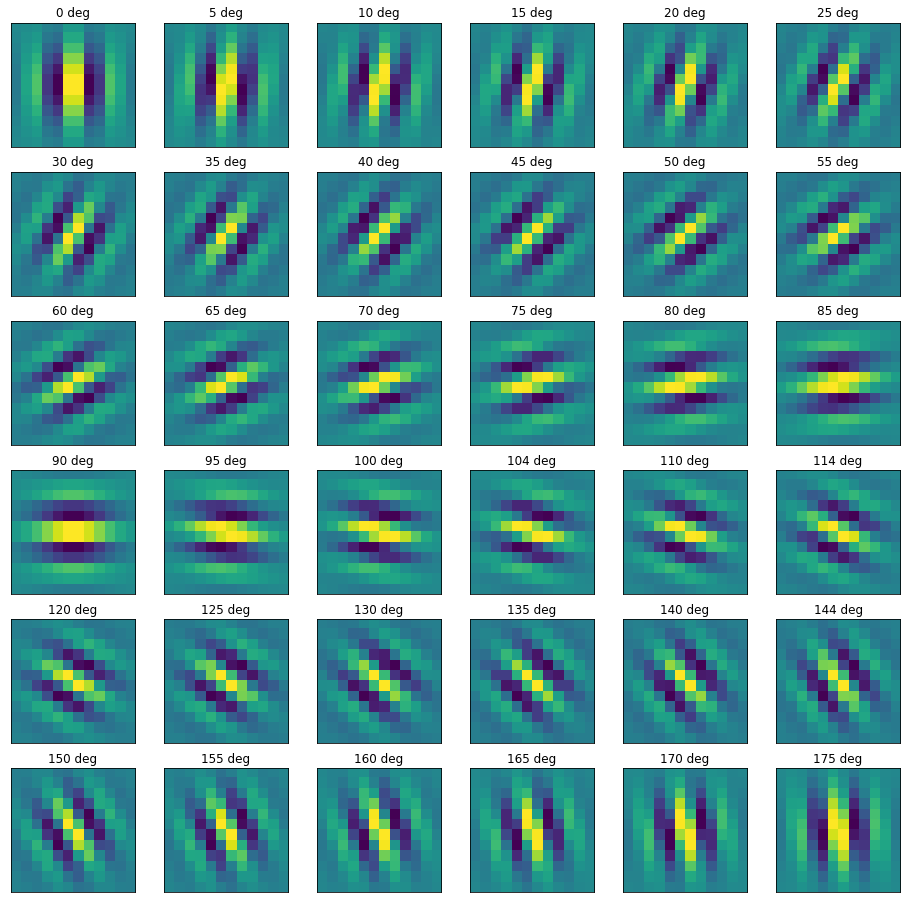

In [4]:
## Visualize the orientation filters (also double check the labels for degrees here)
# Note these are complex numbers, showing real parts only here. If you plot imaginary, will be 90 deg out of phase.

plt.figure(figsize=(16,16));
for ff in range(36):
    
    plt.subplot(6,6,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,0,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

In [6]:
sf_tuning_masks

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      